# Chapter 5. Backpropagation

BP를 설명하는 두 가지 방법
    * 수식: 일반적 방법, 대부분의 책에서 주로 사용, 정확하고 간결
    * 계산 그래프: 시각적으로 이해, CS231n 수업

계산 그래프, computational graph, 는 계산 과정을 그래프로 나타낸 것이다. <br>
(계산 그래프의 이점)
1. 국소적 계산: 현재 계산이 이전 계산이나 이후 계산의 영향을 받지 않는다. 전체가 아무리 복잡해도 각 노드에선 단순한 계산에 집중하여 문제를 단순화 할 수 있다. 
2. 중간 계산 결과를 모두 보관할 수 있다.<br>
3. 역전파를 통해 미분을 효율적으로 계산할 수 있다. 

국소적 미분을 전달하는 원리는 chain rule 연쇄법칙에 따른다. 

In [28]:
import numpy as np

---
Ex. apple, orange 

In [5]:
class MulLayer:
    def __init__(self):
        self.x=None
        self.y=None
    def forward(self,x,y):
        self.x=x
        self.y=y
        out=x*y
        return out
    def backward(self,dout):
        dx=dout*self.y
        dy=dout*self.x
        return dx,dy
class AddLayer:
    def __init__(self):
        pass
    def forward(self,x,y):
        self.x=x
        self.y=y
        return x+y
    def backward(self,dout):
        dx=dout
        dy=dout
        return dx,dy

In [8]:
num_apple=2.
price_apple=100.
num_orange=3.
price_orange=150.
tax=1.1

mul_apple_layer=MulLayer()
mul_orange_layer=MulLayer()
sum_price_layer=AddLayer()
mul_tax_layer=MulLayer()

apple_tot=mul_apple_layer.forward(price_apple,num_apple)
orange_tot=mul_orange_layer.forward(price_orange,num_orange)
price_tot=sum_price_layer.forward(apple_tot,orange_tot)
price=mul_tax_layer.forward(price_tot,tax)
print(price)

dprice=1
dprice_tot,dtax=mul_tax_layer.backward(dprice)
dapple_tot,dorange_tot=sum_price_layer.backward(dprice_tot)
dnum_apple,dprice_apple=mul_apple_layer.backward(dapple_tot)
dnum_orange,dprice_orange=mul_orange_layer.backward(dorange_tot)
print(dnum_apple,dprice_apple,dprice_orange,dnum_orange,dtax)

715.0000000000001
2.2 110.00000000000001 165.0 3.3000000000000003 650.0


---
### activation functions

In [11]:
# ReLU
class ReLU:
    def __init__(self):
        self.mask=None
    def forward(self,x):
        self.mask=(x<=0)
        out=x.copy()
        out[self.mask]=0
        return out
    
    def backward(self,dout):
        dx=dout.copy()
        dx[self.mask]=0
        return dx

In [14]:
# Sigmoid
class Sigmoid:
    def __init__(self):
        self.out=None
    def forward(self,x):
        out=1/(1+np.exp(-x))
        self.out=out
        return out
    def backward(self,dout):
        dx=(self.out)(1-self.out)*dout
        return dx

---
### Affine layer 
신경망의 순전파 때 수행하는 행렬의 내적을 기하학에서 affine transformation 어파인 변환 이라 한다. <br>
책에서는 어파인 변환을 수행하는 처리를 'affine 계층' 이라는 이름으로 구현한다. 

In [15]:
class Affine:
    def __init__(self,W,b):
        self.W=W
        self.b=b
        self.x=None
        self.dW=None
        self.db=None
    
    def forward(self,x):
        self.x=x
        out=np.dot(x,self.W)+self.b
        return out

    def backward(self,dout):
        dx=np.dot(dout,self.W.T)
        self.dW=np.dot(self.X.T,dout)
        self.db=np.sum(dout,axis=0)
        return dx

추론할 때는 일반적으로 softmax계층 사용 안한다. 이러한 정규화하지 않은 출력 결과를 점수라고 한다. <br>
신경망 추론에서 답을 하나만 내는 경우에는 가장 높은 점수만 알면 되므로 softmax 층이 필요 없다. <br>
허나 학습할 때는 softmax 층이 필요하다. 

---
### Softmax-with-Loss layer
softmax layer + cross entropy error layer <br>
softmax 계층은 입력 a를 정규화하여 y를 출력<br>
cross entropy error layer 는 y와 정답 레이블 t를 받고, 손실 L을 출력<br>
신경망 학습의 중요한 성질로 softmax layer의 역전파는 y-t 라는 말끔한 결과를 가진다. 이는 softmax 계층 출력과 정답 레이블의 차분을 의미한다. 이것이 softmax layer의 역전파가 된다는 결과는 신경망 학습의 중요한 성질이다. <br>
소프트맥스 함수의 손실함수로 교차 엔트로피 오차를 사용했을때 역전파에서 나타나는 말끔한 결과는 우연이 아니라 교차 엔트로피 오차 함수가 그렇게 설계되어있기 떄문이다.<br>
마찬가지로 회귀 출력층에서 사용하는 항등함수의 손실함수로 평균 제곱 오차를 이용하는 이유도 이와 같다. <br>
즉 항등 함수의 손실 함수로 평균 제곱 오차를 사용하면 역전파의 결과가 y-t 로 말끔히 떨어진다. 


In [17]:
def softmax(a):
    max_a=np.max(a)
    exp_a=np.exp(a-max_a)
    sum_exp_a=np.sum(exp_a)
    y=exp_a/sum_exp_a
    return y

def cross_entropy_error(y,t):
    if y.ndim==1:
        t=t.reshape(1,t.size)
        y=y.reshape(1,y.size)
    batch_size=y.shape[0]
    return -np.sum(t*np.log(y+1e-7))/batch_size


class SoftmaxWithLoss:
    def __init__(self):
        self.loss=None
        self.y=None
        self.t=None
    def forward(self,x,t):
        self.t=t
        self.y=softmax(x)
        self.loss=cross_entropy_error(self.y,self.t)
        return self.loss
    def backward(self,dout=1):
        batch_size=self.t.shape[0]
        dx=(self.y-self.t)/batch_size
        return dx

---
## Final: Two layer neural network class

In [33]:
from collections import OrderedDict
from common.gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self,input_size,hidden_size,output_size,weight_init_std=0.01):
        # param init
        self.params={}
        self.params['W1']=weight_init_std*np.random.randn(input_size,hidden_size)
        self.params['b1']=np.zeros(hidden_size)
        self.params['W2']=weight_init_std*np.random.randn(hidden_size,output_size)
        self.params['b2']=np.zeros(output_size)
        
        # layer construction
        self.layers = OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
        self.layers['Relu1']=ReLU()
        self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])
        self.lastlayer=SoftmaxWithLoss()
        
    def predict(self,x):
        for layer in self.layers.values():
            x=layer.forward(x)
        return x

    def loss(self,x,t):
        y=self.predict(x)
        return self.lastlayer.forward(y,t)
    
    def accuracy(self,x,t):
        y=self.predict(x)
        y=np.argmax(y,axis=1)
        if t.ndim != 1 : t=np.argmax(t,axis=1)
        accuracy=np.sum(y==t)/float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self,x,t):
        loss_W=lambda W: self.loss(x,t)
        
        grads={}
        grads['W1']=numerical_gradient(loss_W,self.params['W1'])
        grads['b1']=numerical_gradient(loss_W,self.params['b1'])
        grads['W2']=numerical_gradient(loss_W,self.params['W2'])
        grads['b2']=numerical_gradient(loss_W,self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        # forward propagation
        self.loss(x,t)
        
        # backward propagation
        dout=1
        dout=self.lastlayer.backward(dout)
        
        layers=list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout=layer.backward(dout)
        
        grads={}
        grads['W1']=self.layers['Affine1'].dW
        grads['b1']=self.layers['Affine1'].db
        grads['W2']=self.layers['Affine2'].dW
        grads['b2']=self.layers['Affine2'].db
        
        return grads

In [35]:
import sys,os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True,flatten=True,one_hot_label=True)
network=TwoLayerNet(input_size=784,hidden_size=50,output_size=10)

x_batch=x_train[:3]
t_batch=t_train[:3]

grad_numerical=network.numerical_gradient(x_batch,t_batch)
grad_backprop=network.gradient(x_batch,t_batch)

for key in grad_numerical.keys():
    diff=np.average(np.abs(grad_backprop[key]-grad_numerical[key]))
    print(key+' : '+str(diff))

W1 : 7.44650653038e-08
b1 : 1.7053493014e-06
W2 : 6.18614824926e-09
b2 : 1.40221086428e-07


---
## Implementation: two layer neural network

In [37]:
(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True,flatten=True,one_hot_label=True)
network=TwoLayerNet(input_size=784,hidden_size=50,output_size=10)

iters_num=10000
train_size=x_train.shape[0]
batch_size=100
learning_rate=0.1

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]

iter_per_epoch=max(train_size/batch_size,1)

for i in range(iters_num):
    batch_mask=np.random.choice(train_size,batch_size)
    x_batch=x_train[batch_mask]
    t_batch=t_train[batch_mask]
    
    grad=network.gradient(x_batch,t_batch)
    
    for key in ('W1','b1','W2','b2'):
        network.params[key]-=learning_rate*grad[key]
        
    loss=network.loss(x_batch,t_batch)
    train_loss_list.append(loss)
    
    if i%iter_per_epoch==0:
        train_acc=network.accuracy(x_train,t_train)
        test_acc=network.accuracy(x_test,t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc,test_acc)

0.0860166666667 0.0837
0.901616666667 0.9035
0.924816666667 0.9274
0.9344 0.9346
0.943883333333 0.9425
0.951933333333 0.9486
0.956966666667 0.954
0.96005 0.9557
0.963683333333 0.9587
0.967966666667 0.9622
0.970216666667 0.9659
0.972333333333 0.9662
0.973216666667 0.9671
0.973683333333 0.9669
0.976316666667 0.9684
0.977683333333 0.9693
0.979033333333 0.9709


<IPython.core.display.Javascript object>


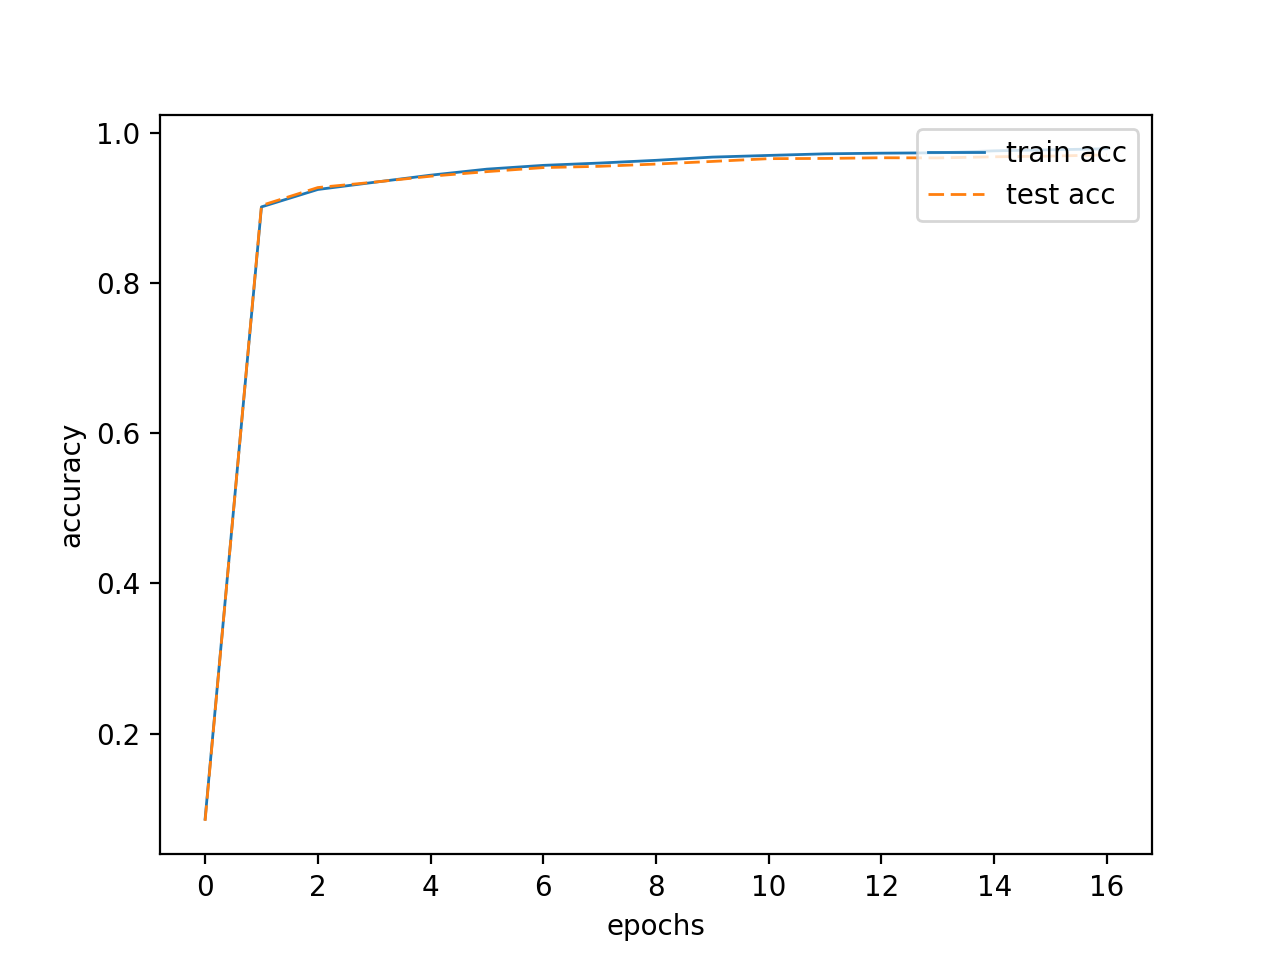

In [38]:
%matplotlib notebook
import matplotlib.pylab as plt
line1,=plt.plot(range(17),train_acc_list[:17],label='train acc',linewidth=1)
line2,=plt.plot(range(17),test_acc_list[:17],label='test acc',linestyle='--',linewidth=1)
legend = plt.legend(handles=[line1,line2], loc=1)
plt.xlabel('epochs')
plt.ylabel('accuracy')

5장 정리: 
    * 계산 그래프를 이용해 계산 과정을 시각적으로 파악가능하다.
    * 계산 그래프 노드는 국소적 계산으로 구성된다. 국소적 계산을 조합해 전체 계산을 구성
    * 계산 그래프의 역전파로 각 노드의 미분을 구할 수 있다. 
    * 신경망의 구성 요소를 계층으로 구현하여 기울기를 효율적으로 계산할 수 있다. (backpropagation)
    * 수치 미분과 오차역전파법의 결과 비교시 오차역전파법의 구현에 잘못이 없는지 확인할 수 있다. (기울기 확인)